In [3]:
from MatlabFuncs import *
from model import *
from triangle import *
from bamg import bamg
from savevars import *
import plotdoc
from loadmodel import *
import os
from os.path import exists

from export_netCDF import export_netCDF

from scipy.io import loadmat
from m1qn3inversion import *
import numpy as np
from ContourToNodes import *
from solve import *

#import lhsmdu #install in terminal 'pip install lhsmdu'
import matplotlib.pyplot as plt
import pickle

import numpy as np
from osgeo import gdal
from matplotlib import pyplot as plt

from InterpFromGridToMesh import InterpFromGridToMesh
from InterpFromMeshToMesh2d import InterpFromMeshToMesh2d

import copy
import utilities
from reinitializelevelset import *

In [ ]:
region = 'SAtoES'
start_year  = 1985.

In [ ]:
# Load a separate model to extract the friction coefficient and rheology
md_friction = loadmodel("./Models/SAtoES_friction_coefficient.nc")
friction_coefficient = md_friction.results.StressbalanceSolution.FrictionCoefficient
rheology_B = md_friction.materials.rheology_B
md_friction = None

# Load the original model
md = loadmodel("./Models/SAtoES_inversion.nc")
md.friction.coefficient = friction_coefficient
md.materials.rheology_B = rheology_B

md.levelset.spclevelset = np.nan * np.ones((md.mesh.numberofvertices))
pos = md.mesh.vertexonboundary == 1
#pos = np.where(md.mesh.vertexonboundary)
md.levelset.spclevelset[pos] = md.mask.ice_levelset[pos]
md.levelset.migration_max = 1e10
plotmodel(md, 'data', md.mask.ice_levelset)

In [ ]:
## Relaxation
relaxation_years = 30 #try 5 years if 1 runs quickly

# Special post-processing of inverted friction coefficient
filename = 'Exp/' + region + '_coeffront_after_inversion.exp'
if os.path.isfile(filename):
  print('adjusting inverted friction coefficient at the glacier fronts')
  pos = find(ContourToNodes(md.mesh.x, md.mesh.y, filename, 1))
  md.friction.coefficient[pos] = 10

md.initialization.pressure = np.zeros([md.mesh.numberofvertices,1])
md.initialization.temperature = 250*np.ones([md.mesh.numberofvertices,1]) #temperature is in kelvin

# Set parameters
md.inversion.iscontrol=0;
md.timestepping.start_time = start_year;
md.timestepping.time_step  = .02;
md.timestepping.final_time = start_year + relaxation_years;
md.settings.output_frequency = (1/md.timestepping.time_step)/5; # 5/yr

In [ ]:
# define fjord walls/flush where bed > 0 (code added 8/3/22)
n_buffer = 2
for i in range(n_buffer):
    elements = md.mesh.elements.astype(int)-1
    nodes_edge = elements[np.where(np.sum(md.mask.ice_levelset[elements] == -1, axis=1) == 2)[0]]
    nodes_edge = np.unique(nodes_edge.ravel())
    nodes_bed = np.where(md.geometry.bed > 0)[0]
    nodes_edge_bed = np.array(list(set(nodes_edge) & set(nodes_bed)))
    plt.plot(md.mesh.x[nodes_edge_bed], md.mesh.y[nodes_edge_bed], 'r.', markersize=10)

    md.mask.ice_levelset[nodes_edge_bed] = -1
    md.geometry.thickness[nodes_edge_bed] = 10
    md.geometry.surface[nodes_edge_bed] = md.geometry.bed[nodes_edge_bed] + md.geometry.thickness[nodes_edge_bed]

    md.friction.coefficient[nodes_edge_bed] = 200

In [ ]:
# defining thermal and sub. discharge at every ISSM mesh node 

# load raster of basins
ds = gdal.Open('./Cheat_matfiles/tidewaterbasins_rignotid.mat_tidewaterbasins.tif', gdal.GA_ReadOnly)
rb = ds.GetRasterBand(1)
basins_array = rb.ReadAsArray()

gt = ds.GetGeoTransform()
ulx, xres, xskew, uly, yskew, yres  = gt
lrx = ulx + (ds.RasterXSize * xres)
lry = uly + (ds.RasterYSize * yres)
x = np.arange(ulx, lrx,  xres)
y = np.arange(lry, uly, -yres)

In [ ]:
# interpolate basin to each mesh node 
px = np.array( ((md.mesh.x - gt[0]) / gt[1]).astype(int) )
py = np.array( ((md.mesh.y - gt[3]) / gt[5]).astype(int) )

basins_mesh = basins_array[py.astype(int), px.astype(int)]

# ISSM wants basins to be numbered from 1 to 4 with the basins that we don't care about numbered 0
basins_mesh[basins_mesh==13] = 1
basins_mesh[basins_mesh==52] = 2
basins_mesh[basins_mesh==53] = 3
basins_mesh[basins_mesh==90] = 4
basins_mesh[(basins_mesh<1) | (basins_mesh>4)] = 0

# find basin id for each element
basins_elements = basins_mesh[md.mesh.elements-1]
basins_elements = np.max(basins_elements, axis=1)

plotmodel(md, 'data', basins_elements)

In [ ]:
# Assigning ocean thermal (EN4) and subglacial discharge (RACMO2.3p2) forcings
from scipy_io_utils import *

# Load historical forcing data
glacier_list = list()
m = loadmat('./Cheat_matfiles/glacier0013.mat')
glacier0013 = m['glacier0013']
m = loadmat('./Cheat_matfiles/glacier0052.mat')
glacier0052 = m['glacier0052']
m = loadmat('./Cheat_matfiles/glacier0053.mat')
glacier0053 = m['glacier0053']
m = loadmat('./Cheat_matfiles/glacier0090.mat')
glacier0090 = m['glacier0090']

# Thermal forcing
t = glacier0013['EN4']['t']
TF = glacier0013['EN4']['TF']

# Discharge
t = glacier0013['RACMO']['Q']
Q = glacier0013['RACMO']['Q']

from frontalforcingsrignot import frontalforcingsrignot
md.frontalforcings = frontalforcingsrignot()
valid = ~np.isnan(glacier0013['EN4']['TF'])
md.frontalforcings.thermalforcing = np.zeros( (md.mesh.numberofvertices+1, len(glacier0013['EN4']['TF'][valid])) )
md.frontalforcings.subglacial_discharge = np.zeros( (md.mesh.numberofvertices+1, len(glacier0013['RACMO']['Q'])) )

In [ ]:
# Assign forcings to correct node 

# step 1: find which nodes belong to each basin using basin_mesh
get_indexes = lambda basins_mesh, xs: [i for (y, i) in zip(xs, range(len(xs))) if basins_mesh == y]
glacier13_nodes = get_indexes(1,basins_mesh)
glacier52_nodes = get_indexes(2,basins_mesh)
glacier53_nodes = get_indexes(3,basins_mesh)
glacier90_nodes = get_indexes(4,basins_mesh)

# NOTE: Denis combined steps 2 and 3: we select the rows and set to the TF time series
# step 2: select() rows from frontalforcings.thermal that correspond to step 1 nodes
md.frontalforcings.thermalforcing[glacier13_nodes,:] = glacier0013['EN4']['TF'][valid]
md.frontalforcings.thermalforcing[glacier52_nodes,:] = glacier0052['EN4']['TF'][valid]
md.frontalforcings.thermalforcing[glacier53_nodes,:] = glacier0053['EN4']['TF'][valid]
md.frontalforcings.thermalforcing[glacier90_nodes,:] = glacier0090['EN4']['TF'][valid]

# step 2: select() rows from frontalforcings.subglacial_discharge that correspond to step 1 nodes
md.frontalforcings.subglacial_discharge[glacier13_nodes,:] = glacier0013['RACMO']['Q'] * 86400
md.frontalforcings.subglacial_discharge[glacier52_nodes,:] = glacier0052['RACMO']['Q'] * 86400
md.frontalforcings.subglacial_discharge[glacier53_nodes,:] = glacier0053['RACMO']['Q'] * 86400
md.frontalforcings.subglacial_discharge[glacier90_nodes,:] = glacier0090['RACMO']['Q'] * 86400

# NOTE: And now, set the last row to the time
md.frontalforcings.thermalforcing[-1,:] = glacier0013['EN4']['t'][valid]
md.frontalforcings.subglacial_discharge[-1,:] = glacier0013['RACMO']['t']

# NOTE: All times are the same for the TF time series for each glacier so we just set the times equal to the glacier0013 times


## Load the parameters for the ensemble

In [ ]:
import pickle
with open('ens_dict.pickle', 'rb') as f:
    ens_data = pickle.load(f)

## Loop through ensemble members and launch ISSM on the cluster

In [ ]:
for trial_name, parameters in ens_data.items():
    print('Launching ' + trial_name)
    
    # We set the transient parameters
    md.transient.ismovingfront=1
    md.transient.isthermal=0
    md.transient.isstressbalance=1
    md.transient.ismasstransport=1
    md.transient.isgroundingline=1
    md.groundingline.migration = 'SubelementMigration'

    # We set the ocean conditions
    md.frontalforcings.basin_id = basins_elements
    md.frontalforcings.num_basins = 4

    # We set the calving model
    from calvingvonmises import calvingvonmises
    md.calving = calvingvonmises()

    # Set the requested outputs
    md.stressbalance.requested_outputs=['default']
    md.transient.requested_outputs=['default','IceVolumeAboveFloatation','BasalforcingsGroundediceMeltingRate','CalvingMeltingrate']

    # SMCE cluster
    from eis_nasa_smce import eis_nasa_smce
    md.cluster = eis_nasa_smce()
    md.cluster.name = 'pcluster.sealevel.eis.smce.nasa.gov'
    md.cluster.partition = 'sealevel-c5n18xl-demand'
    md.cluster.login = 'mpascual'
    md.cluster.idfile = '~/.ssh/id_rsa'
    md.cluster.executionpath = '/efs/mpascual/issm_execution_cluster'
    md.cluster.cpuspernode = 14

    md.settings.waitonlock = 0

    # Go solve
    md.miscellaneous.name = region + '_' + trial_name
    md.verbose.solution = 1
    md = solve(md, 'sb')

    # Save this model 
    export_netCDF(md, '/efs/mpascual/GrIS_Outlet_Glacier_Seasonal_dhdt/Models/' + \
                  region + '_' + '_hindcast_EN4_RACMO_' + trial_name + '_sent2cluster.nc')
    
    print('')
    break

In [ ]:
md = loadmodel("/efs/mpascual/GrIS_Outlet_Glacier_Seasonal_dhdt/Models/SAtoES__hindcast_EN4_RACMO_Trial0_sent2cluster.nc")
md = loadresultsfromcluster(md)
#load md cluster results check sb fric coeff field
fig = plt.figure(figsize=(15,15))
plotmodel(md, 'data', md.results.StressbalanceSolution.Vel[:,0], \
          'mask', md.mask.ice_levelset<0, 'colormap', 'jet', 'caxis', [0,1500])

***

## Ensemble for loop

In [ ]:
# Setup
cluster_username = 'mpascual'


In [6]:
# Global setup of the base model

###################################################
## 1) Load the _param model + common parameters  ##
###################################################
md = loadmodel('/efs/GrIS_Outlet_Glacier_Seasonal_dhdt/Models/SAtoES_Param.nc')

#Setup
region = 'SAtoES'
start_year  = 1985.

#############################
## input seasonal forcings ##
#############################
        
# defining thermal and sub. discharge at every ISSM mesh node 
# load raster of basins
ds = gdal.Open('./Cheat_matfiles/tidewaterbasins_rignotid.mat_tidewaterbasins.tif', gdal.GA_ReadOnly)
rb = ds.GetRasterBand(1)
basins_array = rb.ReadAsArray()
        
gt = ds.GetGeoTransform()
ulx, xres, xskew, uly, yskew, yres  = gt
lrx = ulx + (ds.RasterXSize * xres)
lry = uly + (ds.RasterYSize * yres)
x = np.arange(ulx, lrx,  xres)
y = np.arange(lry, uly, -yres)
        
# interpolate basin to each mesh node 
px = np.array( ((md.mesh.x - gt[0]) / gt[1]).astype(int) )
py = np.array( ((md.mesh.y - gt[3]) / gt[5]).astype(int) )
basins_mesh = basins_array[py.astype(int), px.astype(int)]
        
# ISSM wants basins to be numbered from 1 to 4 with the basins that we don't care about numbered 0
basins_mesh[basins_mesh==13] = 1
basins_mesh[basins_mesh==52] = 2
basins_mesh[basins_mesh==53] = 3
basins_mesh[basins_mesh==90] = 4
basins_mesh[(basins_mesh<1) | (basins_mesh>4)] = 0

# find basin id for each element
basins_elements = basins_mesh[md.mesh.elements-1]
basins_elements = np.max(basins_elements, axis=1)
        
# Assigning ocean thermal (EN4) and subglacial discharge (RACMO2.3p2) forcings
from scipy_io_utils import *

# Load historical forcing data
glacier_list = list()
m = loadmat('./Cheat_matfiles/glacier0013.mat')
glacier0013 = m['glacier0013']
m = loadmat('./Cheat_matfiles/glacier0052.mat')
glacier0052 = m['glacier0052']
m = loadmat('./Cheat_matfiles/glacier0053.mat')
glacier0053 = m['glacier0053']
m = loadmat('./Cheat_matfiles/glacier0090.mat')
glacier0090 = m['glacier0090']

# Thermal forcing
t = glacier0013['EN4']['t']
TF = glacier0013['EN4']['TF']

# Discharge
t = glacier0013['RACMO']['Q']
Q = glacier0013['RACMO']['Q']

from frontalforcingsrignot import frontalforcingsrignot
md.frontalforcings = frontalforcingsrignot()
valid = ~np.isnan(glacier0013['EN4']['TF'])
md.frontalforcings.thermalforcing = np.zeros( (md.mesh.numberofvertices+1, len(glacier0013['EN4']['TF'][valid])) )
md.frontalforcings.subglacial_discharge = np.zeros( (md.mesh.numberofvertices+1, len(glacier0013['RACMO']['Q'])) )
        
# Assign forcings to correct node 
# step 1: find which nodes belong to each basin using basin_mesh
get_indexes = lambda basins_mesh, xs: [i for (y, i) in zip(xs, range(len(xs))) if basins_mesh == y]
glacier13_nodes = get_indexes(1,basins_mesh)
glacier52_nodes = get_indexes(2,basins_mesh)
glacier53_nodes = get_indexes(3,basins_mesh)
glacier90_nodes = get_indexes(4,basins_mesh)

# NOTE: Denis combined steps 2 and 3: we select the rows and set to the TF time series
# step 2: select() rows from frontalforcings.thermal that correspond to step 1 nodes
md.frontalforcings.thermalforcing[glacier13_nodes,:] = glacier0013['EN4']['TF'][valid]
md.frontalforcings.thermalforcing[glacier52_nodes,:] = glacier0052['EN4']['TF'][valid]
md.frontalforcings.thermalforcing[glacier53_nodes,:] = glacier0053['EN4']['TF'][valid]
md.frontalforcings.thermalforcing[glacier90_nodes,:] = glacier0090['EN4']['TF'][valid]

# step 2: select() rows from frontalforcings.subglacial_discharge that correspond to step 1 nodes
md.frontalforcings.subglacial_discharge[glacier13_nodes,:] = glacier0013['RACMO']['Q'] * 86400
md.frontalforcings.subglacial_discharge[glacier52_nodes,:] = glacier0052['RACMO']['Q'] * 86400
md.frontalforcings.subglacial_discharge[glacier53_nodes,:] = glacier0053['RACMO']['Q'] * 86400
md.frontalforcings.subglacial_discharge[glacier90_nodes,:] = glacier0090['RACMO']['Q'] * 86400

# NOTE: And now, set the last row to the time
md.frontalforcings.thermalforcing[-1,:] = glacier0013['EN4']['t'][valid]
md.frontalforcings.subglacial_discharge[-1,:] = glacier0013['RACMO']['t']
    
#####################
## set Calving law ##
#####################
from calvingvonmises import calvingvonmises
md.calving = calvingvonmises()
md.calving.stress_threshold_groundedice = md.calving.stress_threshold_groundedice + (md.calving.stress_threshold_groundedice * 0.5)
    
###################################
## set the transient parameters ##
###################################
md.transient.ismovingfront=1
md.transient.isthermal=0
md.transient.issmb = 0
md.thermal.isenthalpy = 0
md.transient.isstressbalance=1
md.transient.ismasstransport=1
md.transient.isgroundingline=1
md.groundingline.migration = 'SubelementMigration'

# We set the ocean conditions
md.frontalforcings.basin_id = basins_elements
md.frontalforcings.num_basins = 4

###################################
## set the inversion parameters ##
###################################
## Inversion
print('Setting up the inversion')
# Control general
md.inversion=m1qn3inversion(md.inversion)
md.inversion.iscontrol=1
md.verbose.solution = False
md.verbose.control = True
md.verbose.qmu = False

# Cost functions
print(' -> Setting cost function values')
md.inversion.cost_functions=[101, 103, 501]; #Abs, Log, reg
md.inversion.cost_functions_coefficients=np.ones([md.mesh.numberofvertices,len(md.inversion.cost_functions)])
md.inversion.cost_functions_coefficients[:,0]=2000
md.inversion.cost_functions_coefficients[:,1]=40
md.inversion.cost_functions_coefficients[:,2]=1.6e-06

# Where vel==0, set coefficients to 0 (i.e., don't try to match this in model)
print(' -> Removing vel==0 obs from inversion')
pos = md.inversion.vel_obs == 0
md.inversion.cost_functions_coefficients[pos,0] = 0
md.inversion.cost_functions_coefficients[pos,1] = 0

# Controls
print(' -> Setting control parameters')
md.inversion.control_parameters=['FrictionCoefficient']
md.inversion.maxsteps=50
md.inversion.maxiter =100
md.inversion.min_parameters=0.05*np.ones(md.mesh.numberofvertices)
md.inversion.max_parameters=200*np.ones(md.mesh.numberofvertices)
md.inversion.control_scaling_factors=1

# Additional parameters
md.stressbalance.restol=0.01
md.stressbalance.reltol=0.1
md.stressbalance.abstol=np.nan
#md.stressbalance.requested_outputs={'default','DeviatoricStressxx','DeviatoricStressyy','DeviatoricStressxy'}

md.friction.coupling = 2

print('')

###################################
## 2) for loop for each ensemble ##
###################################
import pickle
with open('ens_dict.pickle', 'rb') as f:
    ens_data = pickle.load(f)
    
for trial_name, parameters in ens_data.items():
    print('Launching ' + trial_name)
    
    ####################################################
    ## set friction coefficient and rheology with LHS ##
    ####################################################
    #set sliding law 
    md.friction.p = 1 * np.ones([md.mesh.numberofelements]) #needs to be array from mesh elements
    
    #set ice rheology
    from cuffey import cuffey 
    #Vary Celsius range with LHS
    temperature = -10 + (-10*0.5) #(-15 = cold, -1 = warm)
    # convert celsius to kelvin
    temperature = temperature + 273.15 
    #Calculate rigidity
    rigidity = cuffey(temperature)
    #Set rigidity calculation to rheology
    md.materials.rheology_B = rigidity
    
    ####################
    ## run inversion ##
    ####################
    # SMCE pCluster
    from eis_nasa_smce import eis_nasa_smce
    md.cluster = eis_nasa_smce()
    md.cluster.name = 'pcluster.sealevel.eis.smce.nasa.gov'
    md.cluster.partition = 'sealevel-c5n18xl-demand'
    md.cluster.login = cluster_username
    md.cluster.idfile = '~/.ssh/id_rsa'
    md.cluster.executionpath = '/efs/' + cluster_username + '/issm_execution_cluster'
    md.cluster.numnodes = 1
    md.cluster.cpuspernode = 36
    
    # set if statement for checking inversion files already run
    inversion_model_filename = '/efs/GrIS_Outlet_Glacier_Seasonal_dhdt/Models/inversion_models/' + \
                  region + '_' + '_hindcast_EN4_RACMO_inversion' + trial_name + '_Inversion.nc'
    
    if os.path.exists(inversion_model_filename):
        print('Inversion output already exists: ' + inversion_model_filename)
        print('Skipping inversion solve!')
    else:
        md.inversion.iscontrol = 1 
        md.settings.waitonlock = np.inf
        md.miscellaneous.name = region + '_' + trial_name + '_inversion'
        md = solve(md, 'sb')

        # Save this model 
        export_netCDF(md, inversion_model_filename)
    
    print('')
    
    # Load the inversion model
    md = loadmodel(inversion_model_filename)
    ###############################################
    ## extract friction coefficient ##
    ###############################################
    md.friction.coefficient = md.results.StressbalanceSolution.FrictionCoefficient

    #################################################
    ## Interpolate the 1985 DEM surface elevations ##
    #################################################
    z_1985dem = utilities.interp1985DEM(md.mesh.x, md.mesh.y)
    # Select the points that will be used to create the linear relationship between the two surfaces
    pos = (~np.isnan(z_1985dem - md.geometry.surface)) & (z_1985dem > 700) & (z_1985dem < 1000)
    # Find the linear relationship
    p = np.polyfit(md.geometry.surface[pos], z_1985dem[pos], 1)
    z_polyval = np.polyval(p, md.geometry.surface[pos])
    residuals = z_1985dem[pos] - z_polyval
    # Shift the surface
    surf_shifted = utilities.surface_shift(md, md.geometry.surface, z_1985dem)
    md.geometry.surface = surf_shifted
    
    # Find the points where bed < 0 and the new surface > 42 m
    ice_levelset_original = copy.deepcopy(md.mask.ice_levelset)
    pos = (md.geometry.bed < 0) & (md.geometry.surface > 42) & (md.mask.ice_levelset > 0) & (md.mesh.vertexonboundary == 0)

    # Fill in these points with ice
    md.mask.ice_levelset[pos] = -1
    md.mask.ice_levelset = reinitializelevelset(md, md.mask.ice_levelset)

    md.mask.ice_levelset = md.mask.ice_levelset[:,0]
    
    # Extrapolate friction coefficient
    from scipy.interpolate import griddata
    valid = (ice_levelset_original < 0) & (md.geometry.surface < 300)
    extrap = (md.geometry.bed < 0) & (md.geometry.surface > 42) & (ice_levelset_original > 0) & (md.mesh.vertexonboundary == 0)
    friction_coefficient_extrap = griddata((md.mesh.x[valid], md.mesh.y[valid]), \
                                            md.friction.coefficient[valid], \
                                           (md.mesh.x[extrap], md.mesh.y[extrap]), \
                                            method='nearest')
    md.friction.coefficient[extrap] = friction_coefficient_extrap

    
    
    
    md.levelset.spclevelset = np.nan * np.ones((md.mesh.numberofvertices))
    pos = md.mesh.vertexonboundary == 1
    #md.levelset.spclevelset[pos] = md.mask.ice_levelset[pos]
    md.levelset.migration_max = 1e10
    
    # define fjord walls/flush where bed > 0 (code added 8/3/22)
    #n_buffer = 2
    #for i in range(n_buffer):
     #   elements = md.mesh.elements.astype(int)-1
      #  nodes_edge = elements[np.where(np.sum(md.mask.ice_levelset[elements] == -1, axis=1) == 2)[0]]
       # nodes_edge = np.unique(nodes_edge.ravel())
        #nodes_bed = np.where(md.geometry.bed > 0)[0]
        #nodes_edge_bed = np.array(list(set(nodes_edge) & set(nodes_bed)))
        #plt.plot(md.mesh.x[nodes_edge_bed], md.mesh.y[nodes_edge_bed], 'r.', markersize=10)

    #md.mask.ice_levelset[nodes_edge_bed] = -1
    #md.geometry.thickness[nodes_edge_bed] = 10
    #md.geometry.surface[nodes_edge_bed] = md.geometry.bed[nodes_edge_bed] + md.geometry.thickness[nodes_edge_bed]
    
    #md.friction.coefficient[nodes_edge_bed] = 200

    # Set bed = base for grounded ice
    #md.geometry.base = md.geometry.bed
    #md.geometry.thickness = md.geometry.surface - md.geometry.base
    
    pos = (md.mask.ice_levelset < 0) & (md.mask.ocean_levelset > 0)
    md.geometry.base[pos] = md.geometry.bed[pos]
    md.geometry.surface = md.geometry.base + md.geometry.thickness
    
    ####################
    ## set transient ##
    ####################
    transient_years = 30 #try 5 years if 1 runs quickly
       
    # Set parameters
    md.inversion.iscontrol=0;
    md.timestepping.start_time = start_year;
    md.timestepping.time_step  = .02;
    md.timestepping.final_time = start_year + transient_years;
    md.settings.output_frequency = (1/md.timestepping.time_step)/5; # 5/yr
     
    ###################################
    ## set the transient parameters ##
    ###################################
    md.transient.ismovingfront=1
    md.transient.isthermal=0
    md.transient.issmb = 0
    md.thermal.isenthalpy = 0
    md.transient.isstressbalance=1
    md.transient.ismasstransport=1
    md.transient.isgroundingline=1
    md.groundingline.migration = 'SubelementMigration'
    
    # We set the ocean conditions
    md.frontalforcings.basin_id = basins_elements
    md.frontalforcings.num_basins = 4
    
    # SMCE pCluster
    from eis_nasa_smce import eis_nasa_smce
    md.cluster = eis_nasa_smce()
    md.cluster.name = 'pcluster.sealevel.eis.smce.nasa.gov'
    md.cluster.partition = 'sealevel-c5n18xl-demand'
    md.cluster.login = cluster_username
    md.cluster.idfile = '~/.ssh/id_rsa'
    md.cluster.executionpath = '/efs/' + cluster_username + '/issm_execution_cluster'
    md.cluster.numnodes = 1
    md.cluster.cpuspernode = 36
    
    md.settings.waitonlock = 0
    
    # Go solve
    md.miscellaneous.name = region + '_' + trial_name + '_transient'
    md.verbose.solution = 1
    md = solve(md, 'tr')

    # Save this model 
    export_netCDF(md, '/efs/GrIS_Outlet_Glacier_Seasonal_dhdt/Models/transient_models/' + \
                  region + '_' + '_hindcast_EN4_RACMO_transient' + trial_name + '_sent2cluster.nc')
    
    print('')
        

Opening /efs/GrIS_Outlet_Glacier_Seasonal_dhdt/Models/SAtoES_Param.nc for reading 
group toolkits is empty
group results is empty
Setting up the inversion
converting inversion to m1qn3inversion
 -> Setting cost function values
 -> Removing vel==0 obs from inversion
 -> Setting control parameters

Launching Trial0
eis_nasa_smce_settings.py not found, using default settings
Inversion output already exists: /efs/GrIS_Outlet_Glacier_Seasonal_dhdt/Models/inversion_models/SAtoES__hindcast_EN4_RACMO_inversionTrial0_Inversion.nc
Skipping inversion solve!

Opening /efs/GrIS_Outlet_Glacier_Seasonal_dhdt/Models/inversion_models/SAtoES__hindcast_EN4_RACMO_inversionTrial0_Inversion.nc for reading 
eis_nasa_smce_settings.py not found, using default settings
empty init
eis_nasa_smce_settings.py not found, using default settings
checking model consistency
marshalling file SAtoES_Trial0_transient.bin
uploading input file and queueing script
solve.py: launch
launching solution sequence on remote cluster

You are accessing a U.S. Government information system, which includes, 1. this computer, 2. this computer network, 3. all computers connected to this network including end user systems, 4. all devices and storage media attached to this network or to any computer on this network and 5.cloud and remote information services. This information system is provided for U.S. Government-authorized use only. You have no reasonable expectation of privacy regarding any communication transmitted through or data stored on this information system. At any time, and for any lawful purpose, the U.S. Government may monitor, intercept, search, and seize any communication or data transiting, stored on, or traveling to or from this information system. You are NOT authorized to process classified information on this information system. Unauthorized or improper use of this system may result in suspension or loss of access privileges, disciplinary action, and civil and/or criminal penalties.



Submitted batch job 55123
solve.py: launched!
solve.py: waitonlock
Model results must be loaded manually with md = loadresultsfromcluster(md).
File /efs/GrIS_Outlet_Glacier_Seasonal_dhdt/Models/transient_models/SAtoES__hindcast_EN4_RACMO_transientTrial0_sent2cluster.nc allready exist


Give a new name or "delete" to replace:  1


New file name is 1
field md.solidearth.external is None
WARNING type "int16" is unknown for "frontalforcings.basin_id"
qmu is skipped until it is more stable

Launching Trial1
eis_nasa_smce_settings.py not found, using default settings
Inversion output already exists: /efs/GrIS_Outlet_Glacier_Seasonal_dhdt/Models/inversion_models/SAtoES__hindcast_EN4_RACMO_inversionTrial1_Inversion.nc
Skipping inversion solve!

Opening /efs/GrIS_Outlet_Glacier_Seasonal_dhdt/Models/inversion_models/SAtoES__hindcast_EN4_RACMO_inversionTrial1_Inversion.nc for reading 
eis_nasa_smce_settings.py not found, using default settings
empty init
eis_nasa_smce_settings.py not found, using default settings
checking model consistency
marshalling file SAtoES_Trial1_transient.bin
uploading input file and queueing script
solve.py: launch
launching solution sequence on remote cluster


You are accessing a U.S. Government information system, which includes, 1. this computer, 2. this computer network, 3. all computers connected to this network including end user systems, 4. all devices and storage media attached to this network or to any computer on this network and 5.cloud and remote information services. This information system is provided for U.S. Government-authorized use only. You have no reasonable expectation of privacy regarding any communication transmitted through or data stored on this information system. At any time, and for any lawful purpose, the U.S. Government may monitor, intercept, search, and seize any communication or data transiting, stored on, or traveling to or from this information system. You are NOT authorized to process classified information on this information system. Unauthorized or improper use of this system may result in suspension or loss of access privileges, disciplinary action, and civil and/or criminal penalties.



Submitted batch job 55124
solve.py: launched!
solve.py: waitonlock
Model results must be loaded manually with md = loadresultsfromcluster(md).
File /efs/GrIS_Outlet_Glacier_Seasonal_dhdt/Models/transient_models/SAtoES__hindcast_EN4_RACMO_transientTrial1_sent2cluster.nc allready exist


Give a new name or "delete" to replace:  2


New file name is 2
field md.solidearth.external is None
WARNING type "int16" is unknown for "frontalforcings.basin_id"
qmu is skipped until it is more stable

Launching Trial2
eis_nasa_smce_settings.py not found, using default settings
checking model consistency
marshalling file SAtoES_Trial2_inversion.bin
uploading input file and queueing script
solve.py: launch
launching solution sequence on remote cluster


You are accessing a U.S. Government information system, which includes, 1. this computer, 2. this computer network, 3. all computers connected to this network including end user systems, 4. all devices and storage media attached to this network or to any computer on this network and 5.cloud and remote information services. This information system is provided for U.S. Government-authorized use only. You have no reasonable expectation of privacy regarding any communication transmitted through or data stored on this information system. At any time, and for any lawful purpose, the U.S. Government may monitor, intercept, search, and seize any communication or data transiting, stored on, or traveling to or from this information system. You are NOT authorized to process classified information on this information system. Unauthorized or improper use of this system may result in suspension or loss of access privileges, disciplinary action, and civil and/or criminal penalties.



Submitted batch job 55125
solve.py: launched!
solve.py: waitonlock
waiting for /efs/dfelikso/issm_execution_cluster/SAtoES_Trial2_inversion-03-01-2023-19-52-50-2216/SAtoES_Trial2_inversion.lock hold on... (Ctrl+C to exit)
starting while loop
checking for job completion (time: 3 min 7 sec)       
loading results from cluster


You are accessing a U.S. Government information system, which includes, 1. this computer, 2. this computer network, 3. all computers connected to this network including end user systems, 4. all devices and storage media attached to this network or to any computer on this network and 5.cloud and remote information services. This information system is provided for U.S. Government-authorized use only. You have no reasonable expectation of privacy regarding any communication transmitted through or data stored on this information system. At any time, and for any lawful purpose, the U.S. Government may monitor, intercept, search, and seize any communication or data transiting, stored on, or traveling to or from this information system. You are NOT authorized to process classified information on this information system. Unauthorized or improper use of this system may result in suspension or loss of access privileges, disciplinary action, and civil and/or criminal penalties.



field md.solidearth.external is None


/efs/issm-new/python-modules/repos/trunk-jpl-denis/src/m/contrib/defleurian/netCDF/export_netCDF.py:394: RuntimeWarning: invalid value encountered in remainder
  IsInt = np.sum(np.mod(var, 1)) == 0 and np.all(abs(var) < 2147483647) and len(var) > 0


WARNING type "int16" is unknown for "frontalforcings.basin_id"
qmu is skipped until it is more stable

Opening /efs/GrIS_Outlet_Glacier_Seasonal_dhdt/Models/inversion_models/SAtoES__hindcast_EN4_RACMO_inversionTrial2_Inversion.nc for reading 
eis_nasa_smce_settings.py not found, using default settings
empty init
eis_nasa_smce_settings.py not found, using default settings
checking model consistency
marshalling file SAtoES_Trial2_transient.bin
uploading input file and queueing script
solve.py: launch
launching solution sequence on remote cluster


You are accessing a U.S. Government information system, which includes, 1. this computer, 2. this computer network, 3. all computers connected to this network including end user systems, 4. all devices and storage media attached to this network or to any computer on this network and 5.cloud and remote information services. This information system is provided for U.S. Government-authorized use only. You have no reasonable expectation of privacy regarding any communication transmitted through or data stored on this information system. At any time, and for any lawful purpose, the U.S. Government may monitor, intercept, search, and seize any communication or data transiting, stored on, or traveling to or from this information system. You are NOT authorized to process classified information on this information system. Unauthorized or improper use of this system may result in suspension or loss of access privileges, disciplinary action, and civil and/or criminal penalties.



Submitted batch job 55126
solve.py: launched!
solve.py: waitonlock
Model results must be loaded manually with md = loadresultsfromcluster(md).
field md.solidearth.external is None
WARNING type "int16" is unknown for "frontalforcings.basin_id"
qmu is skipped until it is more stable

Launching Trial3
eis_nasa_smce_settings.py not found, using default settings
checking model consistency
marshalling file SAtoES_Trial3_inversion.bin
uploading input file and queueing script
solve.py: launch
launching solution sequence on remote cluster


You are accessing a U.S. Government information system, which includes, 1. this computer, 2. this computer network, 3. all computers connected to this network including end user systems, 4. all devices and storage media attached to this network or to any computer on this network and 5.cloud and remote information services. This information system is provided for U.S. Government-authorized use only. You have no reasonable expectation of privacy regarding any communication transmitted through or data stored on this information system. At any time, and for any lawful purpose, the U.S. Government may monitor, intercept, search, and seize any communication or data transiting, stored on, or traveling to or from this information system. You are NOT authorized to process classified information on this information system. Unauthorized or improper use of this system may result in suspension or loss of access privileges, disciplinary action, and civil and/or criminal penalties.



Submitted batch job 55127
solve.py: launched!
solve.py: waitonlock
waiting for /efs/dfelikso/issm_execution_cluster/SAtoES_Trial3_inversion-03-01-2023-19-56-45-2216/SAtoES_Trial3_inversion.lock hold on... (Ctrl+C to exit)
starting while loop
checking for job completion (time: 0 min 5 sec)      

KeyboardInterrupt: 

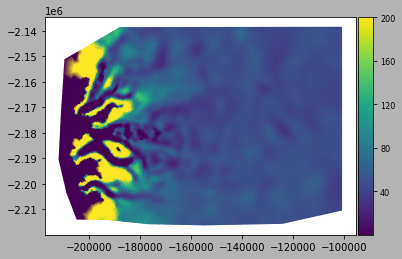

In [14]:
plotmodel(md, 'data', md.results.StressbalanceSolution.FrictionCoefficient)

In [3]:
md = loadmodel('/efs/GrIS_Outlet_Glacier_Seasonal_dhdt/Models/inversion_models/SAtoES__hindcast_EN4_RACMO_inversionTrial0_Inversion.nc')

Opening /efs/GrIS_Outlet_Glacier_Seasonal_dhdt/Models/inversion_models/SAtoES__hindcast_EN4_RACMO_inversionTrial0_Inversion.nc for reading 
You need eis_nasa_smce_settings.py to proceed, check presence and sys.path
eis_nasa_smce_settings.py not found, using default settings
empty init


In [8]:
pos = (md.mask.ice_levelset < 0) & (md.mask.ocean_levelset > 0)
np.max(md.geometry.base[pos] - md.geometry.bed[pos])

md.geometry.base[pos] = md.geometry.bed[pos]
md.geometry.surface = md.geometry.base + md.geometry.thickness

In [9]:
np.min(md.geometry.thickness)

0.40926282746565334

In [12]:
md.geometry.bed.shape

(12112,)

In [13]:
pos.shape

(12112, 12112)

In [17]:
md.mask.ocean_levelset.shape

(12112,)

In [9]:
md = loadmodel('/efs/GrIS_Outlet_Glacier_Seasonal_dhdt/Models/transient_models/SAtoES__hindcast_EN4_RACMO_transientTrial0_sent2cluster.nc')

Opening /efs/GrIS_Outlet_Glacier_Seasonal_dhdt/Models/transient_models/SAtoES__hindcast_EN4_RACMO_transientTrial0_sent2cluster.nc for reading 
eis_nasa_smce_settings.py not found, using default settings
empty init


In [10]:
md.results

    StressbalanceSolution: [1x1 struct]

In [6]:
# Changes in ice velocity
ice_vel_change = md.results.TransientSolution[5].Vel - md.results.TransientSolution[0].Vel
plotmodel(md, 'data', ice_vel_change, 'mask#all', md.mask.ice_levelset<=0)

AttributeError: 'results' object has no attribute 'TransientSolution'